**Localization of a Mobile Robot**

![picture](https://drive.google.com/uc?export=view&id=1ZeYz-O9WdEzwYpwEH-6agLzpLj-isNP0)

In the following exercise you have to complete the Extended Kalman Filter (EKF) implementation that localizes a mobile robot. The robots is equipped with two sensor types:
1. Accelerometer + Gyroscope
2. Fixed anchors with known positions which send distance measurements to the robot.

The accelerometer and the gyroscope are used for the *Prediction step*, while the anchors will be used in the measurement *Update step*. The state of the robot is defined by its position ($x$ and $y$), velocity ($\dot x$ and $\dot y$) and the heading angle (or yaw) $\phi$.
The sensors provide the following information:
Accelerometer: acceleration on the $x$ and $y$ axis
Gyroscope: angular velocity ($\dot \phi)$.
The anchors: continously provide distance information from each anchor to the robot.

System State vector:

$$
\mathbf{x} =
\begin{pmatrix}
p_x \\
p_y \\ 
v_x \\ 
v_ y \\
\varphi
\end{pmatrix}$$


System Dynamics:

\begin{align}
p_x(k+1)&=p_x(k)+v_x(k) \cdot \Delta t + \frac{\Delta t^2}{2} \cdot((a_x+\eta_{a_x}) \cdot c_{\varphi} - (a_y+\eta_{a_y}) \cdot s_{\varphi} )   \\
p_y(k+1)&=p_y(k)+v_y(k) \cdot \Delta t + \frac{\Delta t^2}{2}\cdot ((a_x+\eta_{a_x}) \cdot s_{\varphi} + (a_y + \eta_{a_y}) \cdot c_{\varphi} )   \\
v_x(k+1)&=v_x(k) + \Delta t \cdot ((a_x+\eta_{a_x}) \cdot c_{\varphi} - (a_y+\eta_{a_y}) \cdot s_{\varphi} )  \\
v_y(k+1)&=v_y(k) + \Delta t \cdot ((a_x + \eta_{a_x}) \cdot s_{\varphi} + (a_y+\eta_{a_y}) \cdot c_{\varphi} )  \\
\varphi\left(k+1\right)&=\ \varphi\left(k\right)+\ (\omega + \eta_{\omega})\cdot \Delta t 
\end{align}

\begin{align}
 s_{\varphi} = sin (\varphi(k))   \\
 c_{\varphi} = cos (\varphi(k))
\end{align}


The Measurement Model:
\begin{equation}
z = \sqrt{(p_x - l_x)^2 + (p_y - l_y)^2} + \eta_{s}
\end{equation}
where $l_x$ and $l_y$ are the coordinates of the anchor


**Download the following data:** \\
Trajectory ground-truth: https://drive.google.com/file/d/1hVtQFD-JDDOxML5-DteZS1t_1m2U2ExC/view?usp=sharing

Working sensor data: https://drive.google.com/file/d/1hVtQFD-JDDOxML5-DteZS1t_1m2U2ExC/view?usp=sharing

**Requirements:** \\
1) Write down the Q and R matrices \\
2) Solve the **TODOs 1 2 3 4**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

from numpy import dot
from numpy.random import randn



Load the data you downloaded here:

In [2]:
def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

def compute_error(pos_est, pos_real):
    x_dif = pos_est[:, 0] - pos_real[:, 0]
    y_dif = pos_est[:, 1] - pos_real[:, 1]
    x_dif_sq = np.multiply(x_dif, x_dif)
    y_dif_sq = np.multiply(y_dif, y_dif)
    pos_dif_sum = x_dif_sq + y_dif_sq
    error = np.mean(pos_dif_sum)
    return np.sqrt(error)

In [3]:
def compute_next_state(x, dt, acc_x, acc_y, omega):
    x_ = np.zeros((5,1))
    theta = np.float(x[4])
    x_[0] = x[0] + x[2] * dt + 0.5 * dt ** 2 * (acc_x * np.cos(theta) - acc_y * np.sin(theta))
    x_[1] = x[1] + x[3] * dt + 0.5 * dt ** 2 * (acc_x * np.sin(theta) + acc_y * np.cos(theta))
    x_[2] = x[2] + dt * (acc_x * np.cos(theta) - acc_y * np.sin(theta))
    x_[3] = x[3] + dt * (acc_x * np.sin(theta) + acc_y * np.cos(theta))
    x_[4] = x[4] + omega * dt
    x_[4] = normalize_angle(x_[4])
    return x_

In [4]:
def compute_measurement(x, anchor_xy):
    z_comp = np.sqrt((x[0] - anchor_xy[0]) ** 2 + (x[1] - anchor_xy[1]) ** 2)
    return z_comp

In [5]:
def comp_A(dt, ax, ay, theta):
    A = np.zeros((5,5))
    theta = np.float(theta)
    A[0, 0] = 1; A[0, 2] = dt; A[0, 4] = -0.5 * dt**2 * (ax * np.sin(theta) + ay * np.cos(theta));
    A[1, 1] = 1; A[1, 3] = dt; A[1, 4] = 0.5 * dt**2 * (ax * np.cos(theta) - ay * np.sin(theta));
    A[2, 2] = 1; A[2, 4] = -dt * (ax * np.sin(theta) + ay * np.cos(theta));
    A[3, 3] = 1; A[3, 4] = dt * (ax * np.cos(theta) - ay * np.sin(theta));
    A[4, 4] = 1
    return A

def comp_L(dt, theta):
    L = np.zeros((5,3))
    theta = np.float(theta)
    #####  TODO 1  ##### 
    L[0, 0] = np.cos(theta)*(dt**2)/2
    L[0, 1] = -np.sin(theta)*(dt**2)/2
    L[1, 0] = np.sin(theta)*(dt**2)/2
    L[1, 1] = np.cos(theta)*(dt**2)/2
    L[2, 0] = np.cos(theta)*dt
    L[2, 1] = -np.sin(theta)*dt
    L[3, 0] = np.sin(theta)*dt
    L[3, 1] = np.cos(theta)*dt
    L[4, 2] = dt
    #################### 
    return L

In [6]:
def comp_H(anchor, x):
    H = np.zeros(5)
    #####  TODO 2  ##### 
    lx = anchor[0]
    ly = anchor[1]
    root = np.sqrt((x[0]-lx)**2 + (x[1]-ly)**2)
    H[0] = (x[0]-lx)/root
    H[1] = (x[1]-ly)/root
    H[2] = 0
    H[3] = 0
    H[4] = 0
    #################### 
    return H

In [7]:
def predict(x, u, Pm, Q, dt):
    A = comp_A(dt, u[0], u[1], x[4])
    L = comp_L(dt, x[4])
    xp = compute_next_state(x, dt, u[0], u[1], u[2])
    Pp = dot(A, Pm).dot(A.T) + dot(L, Q).dot(L.T)
    return xp, Pp


def update(xp, Pp, R, anchor, z):
    H = comp_H(anchor, xp).reshape(1, 5)
    inv = 1/(dot(H, Pp).dot(H.T) + R)
    K = dot(Pp, H.T) * inv
    z_pred = compute_measurement(xp, anchor)

    #####  TODO 3  ##### 
    xm = xp + K * (z - z_pred)
    Pm = np.dot((np.identity(5) - np.dot(K, H)), Pp)
    #################### 

    return xm, Pm

In [8]:
# Configuration
process_noise = np.array([10, 10, 1])
sensor_noise = 1
x0 = np.zeros((5, 1))
P0 = np.diag([1, 1, 1, 1, 1])

#####  TODO 4  ##### 
Q = np.diag([100, 100, 1])  # 3x3 numpy array
R = 1 # scalar
#################### 


In [9]:
data = np.genfromtxt("input_data.csv", delimiter=',')
data_real = np.genfromtxt("real_data.csv", delimiter=',')

In [10]:
d = pd.DataFrame(data)
d.head()

,0,1,2,3,4
0,0.000,0.0,-8.654156,-11.689524,2.507957
1,0.000,1.0,39.187117,-10.000000,40.000000
2,0.001,0.0,3.940591,-1.173178,3.003723
3,0.001,1.0,19.720319,20.000000,0.000000
4,0.002,0.0,-2.129960,-11.427466,1.678943


In [11]:
N = data.shape[0]

# Initialize the filter
xm = x0
Pm = P0

# Logging variables
P_est = np.zeros((N//2+1, 5, 5))
P_est[0, :, :] = Pm
x_est = np.zeros((N//2+1, 5))
x_est[0, :] = x0.reshape(1, -1)

time_prev = 0
for i in range(0, N):
    if (data[i, 1] == 0):  # Prediction data
        u = np.array([data[i, 2], data[i, 3], data[i, 4]])
        time = data[i, 0]
        # Predict
        [xp, Pp] = predict(xm, u, Pm, Q, time - time_prev)
        time_prev = time
    else:  # Measurement update data
        z = data[i, 2]
        anchor_xy = np.array([data[i, 3], data[i, 4]])
        # Update
        [xm, Pm] = update(xp, Pp, R, anchor_xy, z)

        x_est[i//2+1, :] = xm.reshape(1, -1)
        P_est[i//2+1, :, :] = Pm


<ipython-input-5-b4ea5a5f9674>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta = np.float(theta)
<ipython-input-5-b4ea5a5f9674>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta = np.float(theta)


In [12]:
# Compute tracking error
error = compute_error(x_est[:, :2], data_real[:, :2])
print("Tracking error: {} m ".format(round(error, 3)))

Tracking error: 0.174 m 


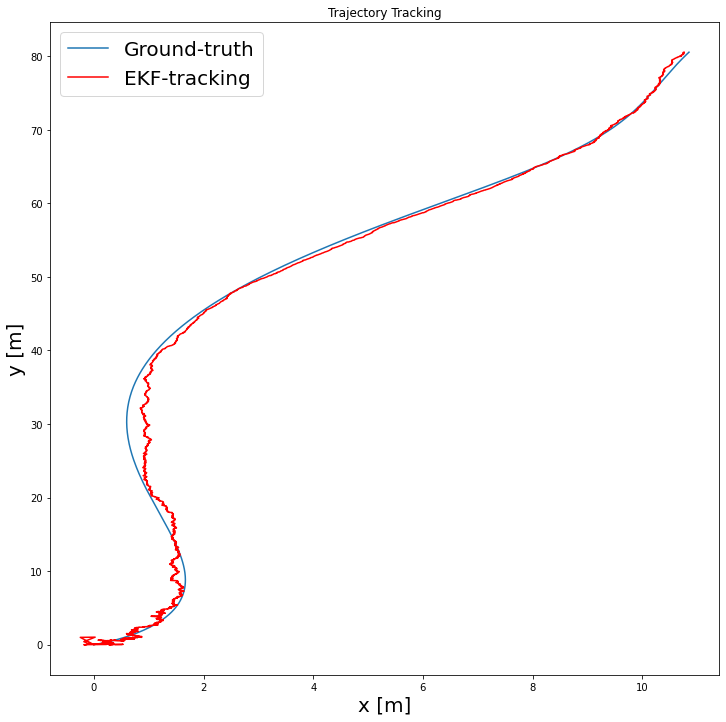

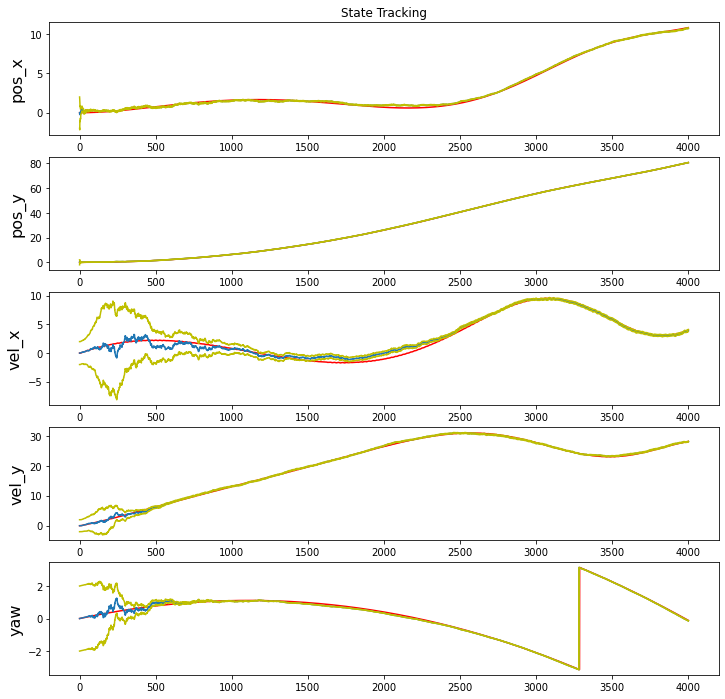

In [13]:
# Plot results
plt.figure(figsize=(12,12))
plt.xlabel("x [m]", fontsize=20)
plt.ylabel("y [m]", fontsize=20)
plt.title("Trajectory Tracking")
plt.plot(data_real[:, 0], data_real[:, 1], label="Ground-truth")
plt.plot(x_est[:, 0], x_est[:, 1], 'r', label="EKF-tracking")
plt.legend(fontsize=20)
plt.figure(figsize=(12,12))

for i in range(0, 5):
    plt.subplot(5, 1, i + 1)
    if i==0:
        plt.title("State Tracking")
    plt.plot(data_real[:, i].T, 'r')
    plt.plot(x_est[:, i].T)

    plt.plot(x_est[:, i].T + 2 * P_est[:, i, i], 'y')
    plt.plot(x_est[:, i].T - 2 * P_est[:, i, i], 'y')
    if i == 0:
      plt.ylabel("pos_x", fontsize=16)
    if i == 1:
      plt.ylabel("pos_y", fontsize=16)
    if i == 2:
      plt.ylabel("vel_x", fontsize=16)
    if i == 3:
      plt.ylabel("vel_y", fontsize=16)
    if i == 4:
      plt.ylabel("yaw", fontsize=16)

plt.show()